In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import pickle
import json

from scipy.stats import pearsonr, spearmanr

## Meta

### Feature relavence analysis taken from Gryffin paper: https://arxiv.org/pdf/2003.12127.pdf

*cations*:  electron_affinity, ionization energy, mass, electronegativity

*anions*:   electron_affinity, ionization energy, mass, electronegativity

*organics*: homo, lumo, dipole, atomization, r_gyr, total_mass

### Evaluators of the bandgap

*cheap evaluator*: GGA level of DFT (`bandgap_gga`)

*exp evaluator*:   HSE06 level of DFT (`bandgap_hse06`)

### Gemini dataset format
`{'fast_features': [...], 'slow_features': [...],
  'fast_targets': [...], 'slow_targets': [...]}`


In [2]:
# load in the features for the individual categorical variables
with open('cations.json', 'r') as content:
    CATIONS = json.load(content)
with open('anions.json', 'r') as content:
    ANIONS = json.load(content)
with open('organics.json', 'r') as content:
    ORGANICS = json.load(content)

In [3]:
np.fromiter(ORGANICS['acetamidinium'].values(), dtype=np.float32)

array([-0.49721  , -0.224    ,  1.3334   , -1.7259337,  1.3441486,
       59.092    ], dtype=float32)

In [4]:
TAB = pickle.load(open('lookup_table.pkl', 'rb'))
# tab[organic_anion][cation][anion]
TAB['Ethylammonium']['Ge']['Cl']['hoip_id']
#TAB['Ethylammonium']['Ge']['']['bandgap_gga']

['0098',
 '0099',
 '0100',
 '0101',
 '0102',
 '0103',
 '0104',
 '0105',
 '0106',
 '0107']

In [5]:
def get_data_point(organic, cation, anion):
    ''' organic, cation, anion are the names or the element symbols
    '''
    # get features
    organic_feat = np.fromiter(ORGANICS[organic].values(), dtype=np.float32)
    anion_feat   = np.fromiter(ANIONS[anion].values(), dtype=np.float32)
    cation_feat  = np.fromiter(CATIONS[cation].values(), dtype=np.float32)

    feat = np.concatenate((organic_feat, anion_feat, cation_feat), axis=0)

    
    # TODO --> what type of reduction operation do I need to do here?? 
    # get slow target (in eV)
    slow_target = np.amin(TAB[organic.capitalize()][cation][anion]['bandgap_hse06'])
    
    # get fast target (in eV)
    fast_target = np.amin(TAB[organic.capitalize()][cation][anion]['bandgap_gga'])
    
    return feat, fast_target, slow_target
    

## construct dataframe of measurements

In [6]:
feat, fast_target, slow_target = get_data_point('ethylammonium', 'Ge', 'F')

In [7]:
feat, fast_target, slow_target

(array([-0.5464   , -0.20326  ,  3.8078   , -1.5113653,  1.2430034,
        46.093    ,  3.401189 , 17.42282  , 18.998    ,  4.       ,
         1.232676 ,  7.8994   , 72.63     ,  1.8      ], dtype=float32),
 4.1048,
 5.3704)

In [8]:
organics = ['ethylammonium', 'propylammonium', 'butylammonium', 'isopropylammonium', 
            'dimethylammonium', 'acetamidinium', 'methylammonium', 'guanidinium', 
            'hydroxylammonium', 'formamidinium', 'tetramethylammonium', 'hydrazinium',
            'ammonium', 'trimethylammonium', 'azetidinium', 'imidazolium']
cations  = ['Ge', 'Sn', 'Pb']
anions   = ['F', 'Cl', 'Br', 'I']

In [9]:
dataset = {'fast_features': [], 'slow_features': [], 
           'fast_targets': [], 'slow_targets': []}

for o_ix, organic in enumerate(organics):
    for c_ix, cation in enumerate(cations):
        for a_ix, anion in enumerate(anions):
            feat, fast_target, slow_target = get_data_point(organic, cation, anion)
            dataset['fast_features'].append(feat)
            dataset['slow_features'].append(feat)
            dataset['fast_targets'].append(fast_target)
            dataset['slow_targets'].append(slow_target)
            

In [10]:
dataset['fast_features'] = np.array(dataset['fast_features'])
dataset['slow_features'] = np.array(dataset['slow_features'])
dataset['fast_targets'] = np.array(dataset['fast_targets'])
dataset['slow_targets'] = np.array(dataset['slow_targets'])

0.9951767001075629 0.9930901183860837


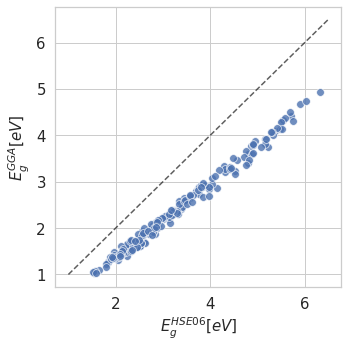

In [33]:
fig=plt.figure(figsize=(5, 5))

pear  = pearsonr(dataset['slow_targets'], dataset['fast_targets'])[0]
spear = spearmanr(dataset['slow_targets'], dataset['fast_targets'])[0]

print(pear, spear)

sns.scatterplot(dataset['slow_targets'], dataset['fast_targets'],
                s=60, alpha=0.8)
plt.plot([1.0, 6.5], [1.0, 6.5], c='k', ls='--', alpha=0.7)
plt.xlabel(r'$E_g^{HSE06} [eV]$', fontsize=15)
plt.ylabel(r'$E_g^{GGA} [eV]$', fontsize=15)

plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('perovskite_agreement.png', dpi=300)
